In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [91]:
import matplotlib.pylab as plt # Para gráficos

In [92]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # Accuracy metrics 

In [94]:
EXPORT_PATH = 'push-up-reload-2.csv'

In [95]:
df = pd.read_csv(EXPORT_PATH)
df['class'].value_counts()

arriba    4378
abajo     2819
Name: class, dtype: int64

In [96]:
X = df.drop('class', axis=1) # features
y = df['class'] # target

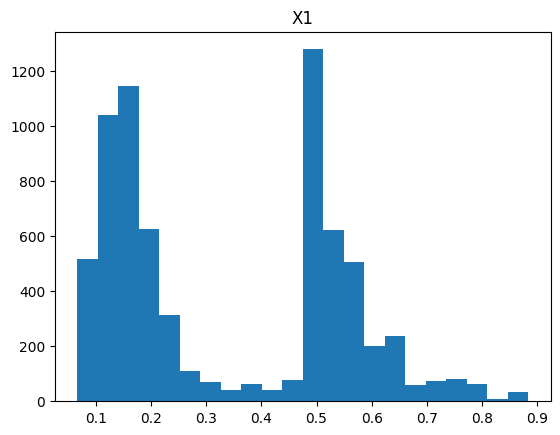

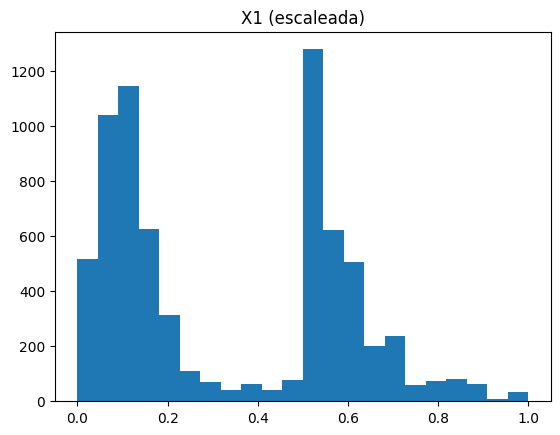

In [97]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X_scale = scaler.transform(X) # aplico la transformacion
plt.hist(X['x1'], bins='auto')  
plt.title("X1")
plt.show()


plt.hist(X_scale[:,0], bins='auto')  
plt.title("X1 (escaleada)")
plt.show()


In [98]:
from sklearn.model_selection import StratifiedKFold
# X_1 = X[:].values

In [ ]:
!pip install catboost

In [99]:
from catboost import CatBoostClassifier
import scipy.stats as st

In [38]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', class_weight='balanced', max_iter=20000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'cb':make_pipeline(StandardScaler(), CatBoostClassifier(thread_count=3, 
                                                            verbose=False,
                                                            n_estimators=st.randint(20,150),
                                                            max_depth=st.randint(3, 12),
                                                            learning_rate=st.uniform(0.05, 0.4),
                                                            colsample_bytree=one_to_left,
                                                            subsample=one_to_left,
                                                            reg_alpha=st.uniform(0.05,10),
                                                            min_child_weight=st.uniform(1,20))),
}

In [100]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [101]:
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [103]:
X_= X_train.reset_index()
y_= y_train.reset_index()

In [104]:
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [105]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', class_weight='balanced', max_iter=20000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'cb':make_pipeline(StandardScaler(), CatBoostClassifier(thread_count=3, verbose=False ))}

In [86]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [15]:
pipelines = {
    'cb':make_pipeline(StandardScaler(), CatBoostClassifier(thread_count=3, verbose=False ))}

pipelines = {
    'cb':make_pipeline(StandardScaler(), CatBoostClassifier(thread_count=3, 
                                                            verbose=False,
                                                            n_estimators=st.randint(20,150),
                                                            max_depth=st.randint(3, 12),
                                                            learning_rate=st.uniform(0.05, 0.4),
                                                            #colsample_bytree=one_to_left,
                                                            subsample=one_to_left,
                                                            #reg_alpha=st.uniform(0.05,10),
                                                            #min_child_weight=st.uniform(1,20))),
                                                            ))}

In [106]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            scaler.fit(X_train_) # encuentro los parametros para el escaleo
            X_train_ = scaler.transform(X_train_) # aplico la transformacion

            scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            scaler.fit(X_test_) # encuentro los parametros para el escaleo
            X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)))
      fit_models[algo] = model
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')
      # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      # auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

      # auc_values.append(auc_test)
      # scores = np.concatenate((scores,probas_test[:,1]),axis=0)
      # indices = np.concatenate((indices,test_index),axis=0)
      fit_models[algo] = model


lr ac-sc: 0.683 pr-sc: 0.786 rc-sc: 0.683
lr ac-sc: 0.802 pr-sc: 0.828 rc-sc: 0.802
lr ac-sc: 0.67 pr-sc: 0.779 rc-sc: 0.67
lr ac-sc: 0.529 pr-sc: 0.779 rc-sc: 0.529
lr ac-sc: 0.842 pr-sc: 0.848 rc-sc: 0.842
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.705 precision_score 0.804 recall_score 0.705
----------------------------------------------------
----------------------------------------------------
rc ac-sc: 0.894 pr-sc: 0.901 rc-sc: 0.894
rc ac-sc: 0.619 pr-sc: 0.717 rc-sc: 0.619
rc ac-sc: 0.628 pr-sc: 0.744 rc-sc: 0.628
rc ac-sc: 0.818 pr-sc: 0.849 rc-sc: 0.818
rc ac-sc: 0.882 pr-sc: 0.886 rc-sc: 0.882
----------------------------------------------------
--------------PROMEDIOS--DE-- rc -------------------------
Accuracy 0.768 precision_score 0.82 recall_score 0.768
----------------------------------------------------
----------------------------------------------------
rf ac-sc: 0.829 pr-sc: 0.856 rc-sc:

In [98]:
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')

----------------------------------------------------
--------------PROMEDIOS--DE-- cb -------------------------
Accuracy 0.966 precision_score 0.967 recall_score 0.966
----------------------------------------------------
----------------------------------------------------


In [ ]:
# Scatter

# importamos las librerias necesarias
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Creamos la figura
fig = plt.figure()
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')

# Definimos los datos de prueba
x = [1,2,3,4,5,6,7,8,9,10]
y = [5,6,7,8,2,5,6,3,7,2]
z = [1,2,6,3,2,7,3,3,7,2]

# Datos adicionales
x2 = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]
y2 = [-5,-6,-7,-8,-2,-5,-6,-3,-7,-2]
z2 = [1,2,6,3,2,7,3,3,7,2]

# Agregamos los puntos en el plano 3D
ax1.scatter(x, y, z, c='g', marker='o')
ax1.scatter(x2, y2, z2, c ='r', marker='o')

# Mostramos el gráfico
plt.show()

In [107]:
fit_models['cb']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000002302D4D2FA0>)])

In [109]:
X_test = X_test.values

In [110]:
y_predicted = fit_models['cb'].predict_proba(X_test)

In [111]:
y_predicted

array([[5.03686403e-04, 9.99496314e-01],
       [9.41576163e-01, 5.84238375e-02],
       [1.95361655e-04, 9.99804638e-01],
       ...,
       [8.58657358e-01, 1.41342642e-01],
       [9.22224263e-01, 7.77757368e-02],
       [3.25038836e-05, 9.99967496e-01]])

In [23]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [41]:
#import pathlib
VIDEO_PATH = 'The Push-Up.mp4'

In [112]:
MODEL_PATH = 'flexiones_cb.pkl'

In [113]:
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(fit_models['cb'], f) 

In [48]:
landmarks = ['class']
for val in range(1,33+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [49]:
X = pd.DataFrame([row], columns=landmarks[1:])
X

,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,0.55348,0.640359,0.028765,0.99997,0.547977,0.625608,0.008614,0.999967,0.548109,0.623971,...,0.122911,0.777689,0.90473,0.902907,-0.177792,0.962311,0.898064,0.877433,0.081102,0.798493


In [50]:
import pickle 
with open(MODEL_PATH, 'rb') as f:
    model = pickle.load(f)

In [57]:
cap = cv2.VideoCapture(VIDEO_PATH)

# Curl counter variables
counter = 0 
current_stage = None

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Detección de Pose
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
        
        # Extract landmarks
        try:
            
            row = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
            X = pd.DataFrame([row], columns=landmarks[1:])
            X=X.values
            body_language_class = model.predict(X)[0]
            
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, body_language_prob)
            
            if body_language_class or body_language_prob:
                print('predicted')
            else :
                print('prediction error')

            if body_language_class == 1 and body_language_prob[body_language_prob.argmax()] >= 0.7:
                current_stage = "arriba"
                # print(current_stage)
            elif current_stage=="arriba" and body_language_class==0 and body_language_prob[body_language_prob.argmax()] >= 0.7:
                current_stage = "Abajo"
                print(current_stage)
                counter +=1
                
            # obtener el estado del box
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
            # Mostrar las clases
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(body_language_class.split(' ')[0])
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Mostrar Probabilidad
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                       , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Mostrar Conteo
            cv2.putText(image, 'COUNT'
                        , (180,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter)
                        , (175,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
  
        except Exception as e:
            pass

        cv2.imshow('En vivo sin procesar', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

1 [0.22 0.78]
predicted
1 [0.2 0.8]
predicted
1 [0.21 0.79]
predicted
1 [0.22 0.78]
predicted
1 [0.23 0.77]
predicted
1 [0.23 0.77]
predicted
1 [0.23 0.77]
predicted
1 [0.22 0.78]
predicted
1 [0.22 0.78]
predicted
1 [0.23 0.77]
predicted
1 [0.23 0.77]
predicted
1 [0.19 0.81]
predicted
1 [0.18 0.82]
predicted
1 [0.19 0.81]
predicted
1 [0.22 0.78]
predicted
1 [0.23 0.77]
predicted
1 [0.23 0.77]
predicted
1 [0.27 0.73]
predicted
1 [0.31 0.69]
predicted
1 [0.3 0.7]
predicted
1 [0.33 0.67]
predicted
1 [0.32 0.68]
predicted
1 [0.34 0.66]
predicted
1 [0.35 0.65]
predicted
1 [0.39 0.61]
predicted
1 [0.4 0.6]
predicted
1 [0.39 0.61]
predicted
1 [0.4 0.6]
predicted
1 [0.41 0.59]
predicted
1 [0.41 0.59]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.46 0.54]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.47 0.53]
predicted
1 [0.46 0.54]
predicted


In [81]:
y_predicted.argmax()

261

In [ ]:
!pip install scikit-plot

In [80]:
from scikitplot.metrics import plot_roc

<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

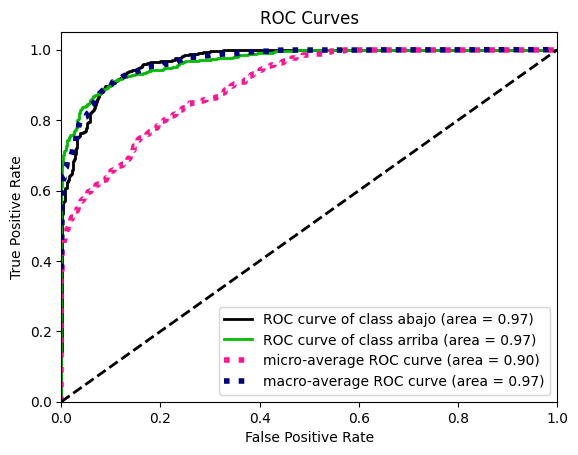

In [82]:
plot_roc(y_test, y_predicted)

In [83]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


<Figure size 2000x2000 with 0 Axes>

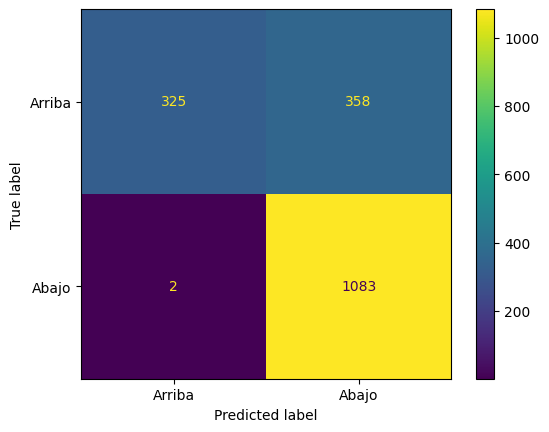

In [84]:

plt.figure(figsize=(20, 20))
class_names = ['Arriba', 'Abajo']

# clf = GradientBoostingClassifier(random_state=42)
# clf.fit(X_train, y_train)
predictions = fit_models['cb'].predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show()

Gráfica de metricas

In [ ]:
from sklearn.model_selection import cross_val_predict

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # Accuracy metrics 
import pickle 

In [114]:
MODEL_PATH_1 = 'flexiones_rf.pkl'
MODEL_PATH_2 = 'flexiones_gb.pkl'
MODEL_PATH_3 = 'flexiones_cb.pkl'

In [115]:
with open(MODEL_PATH_1, 'wb') as f:
    pickle.dump(fit_models['rf'], f)
    
with open(MODEL_PATH_2, 'wb') as f:
    pickle.dump(fit_models['gb'], f)

with open(MODEL_PATH_3, 'wb') as f:
    pickle.dump(fit_models['cb'], f)        

In [109]:
with open(MODEL_PATH_3, 'wb') as f:
    pickle.dump(fit_models['cb'], f) 
    

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))  

In [ ]:
from sklearn.metrics import confusion_matrix